## Import File Image

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py

from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [11]:
h5_path = 'C://Users//User//Downloads//Pattern Recognition Project//HDF5//image_data.h5'

X_train = []
y_train = []
X_test = []
y_test = []
X_valid = []
y_valid = []

In [12]:
def segment_background(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, segmented_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
    return segmented_image

In [13]:
def preprocess_image(h5_path, size=(50, 50)):
    with h5py.File(h5_path, 'r') as h5_file:
        for split in ['train', 'test' , 'valid']:
            split_group = h5_file[split]
            for category in split_group.keys():
                category_group = split_group[category]
                print(category)
                if category != ".ipynb_checkpoints":
                    label = int(category) 
                for image_name in category_group.keys():
                    image_data = category_group[image_name][()]
                    resized_image = cv2.resize(image_data, size)
                    if split == 'train':
                        X_train.append(resized_image)
                        y_train.append(label)
                    elif split == 'test':
                        X_test.append(resized_image)
                        y_test.append(label)
                    elif split == 'valid':
                        X_valid.append(resized_image)
                        y_valid.append(label)

    return image_data, resized_image, label

In [14]:
def visualize_before_after(original, resized, title):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title(f'{title} - Original')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(resized, cmap='gray')
    plt.title(f'{title} - Resized')
    plt.axis('off')
    plt.show()

0
1
2
3
0
1
2
3
0
1
2
3


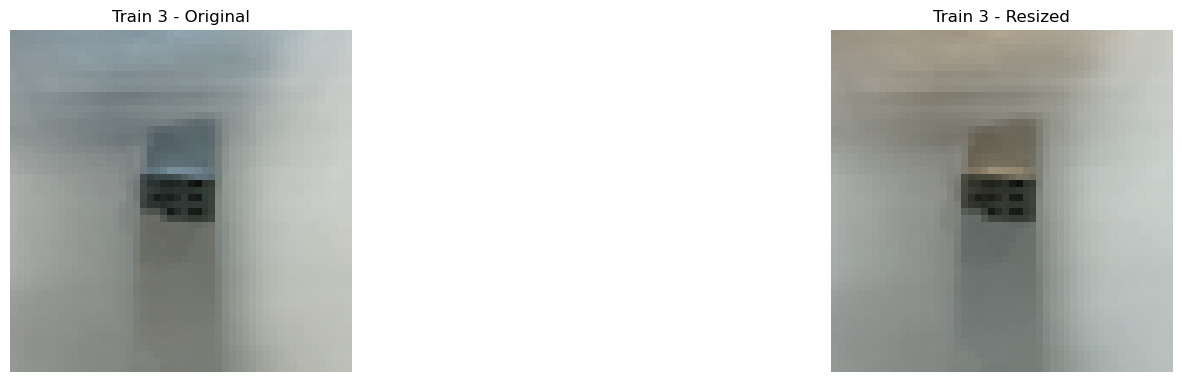

In [15]:
original, resized, label = preprocess_image(h5_path)
visualize_before_after(original, resized, f'Train {label}')

In [16]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_train shape: (744, 50, 50, 3)
y_train shape: (744,)
X_test shape: (248, 50, 50, 3)
y_test shape: (248,)
X_valid shape: (248, 50, 50, 3)
y_valid shape: (248,)


In [17]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_valid = X_valid / 255.0

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_valid_flat = X_valid.reshape(X_test.shape[0], -1)

## PCA Preprocessing

In [18]:
pca = PCA(n_components=4)

In [19]:
x_train_reduced = pca.fit_transform(X_train_flat)

In [20]:
x_test_reduced = pca.transform(X_test_flat)

In [21]:
x_valid_reduced = pca.transform(X_valid_flat)

## Model Training

### KNN

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

def perform_grid_search(model, param_grid, X_train, y_train, cv=5, scoring='accuracy', verbose=1, n_jobs=-1):

    # Initialize the GridSearchCV object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                               cv=cv, scoring=scoring, verbose=verbose, n_jobs=n_jobs)
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator and best parameters
    best_estimator = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"Best Parameters: {best_params}")
    return best_estimator, best_params

# Define the model
#Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
model =  KNeighborsClassifier()

# Define the parameter grid for SVM
param_grid = {
    
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  
   
}

# Perform grid search
knn_best_model, best_hyperparams = perform_grid_search(model, param_grid, x_train_reduced, y_train)

# Evaluate the best model on the test set
y_pred = knn_best_model.predict(x_test_reduced)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


In [23]:
knn = knn_best_model

knn.fit(x_train_reduced, y_train)

train_pred_knn = knn.predict(x_train_reduced)
test_pred_knn = knn.predict(x_test_reduced)
valid_pred_knn = knn.predict(x_valid_reduced)

train_accuracy_knn = accuracy_score(y_train, train_pred_knn)
test_accuracy_knn = accuracy_score(y_test, test_pred_knn)
valid_accuracy_knn = accuracy_score(y_valid, valid_pred_knn)

print("KNN Training Accuracy: {:.2f}%".format(train_accuracy_knn * 100))
print("KNN Testing Accuracy: {:.2f}%".format(test_accuracy_knn * 100))
print("KNN Validation Accuracy: {:.2f}%".format(valid_accuracy_knn * 100))

print("Classification Report: \n", classification_report(y_test, test_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, test_pred_knn))

KNN Training Accuracy: 100.00%
KNN Testing Accuracy: 77.02%
KNN Validation Accuracy: 77.02%
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.68      0.76        62
           1       0.78      0.73      0.75        62
           2       0.86      0.77      0.81        62
           3       0.65      0.90      0.76        62

    accuracy                           0.77       248
   macro avg       0.79      0.77      0.77       248
weighted avg       0.79      0.77      0.77       248

Confusion Matrix:
 [[42  4  1 15]
 [ 3 45  5  9]
 [ 0  8 48  6]
 [ 3  1  2 56]]


## KMeans

In [24]:
# Build the clustering model
kmeans = KMeans(n_clusters=4)
kmeans.fit(x_train_reduced)

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


KMeans(n_clusters=4)

In [25]:
y_pred_test_kmeans = kmeans.predict(x_test_reduced)
accuracy_kmeans = accuracy_score(y_test, y_pred_test_kmeans)
print("KMeans Clustering Accuracy: {:2f}%".format(accuracy_kmeans * 100))
print("Classification Report:\n", classification_report(y_test, y_pred_test_kmeans))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_kmeans))

KMeans Clustering Accuracy: 25.403226%
Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.39      0.26        62
           1       0.54      0.31      0.39        62
           2       0.00      0.00      0.00        62
           3       0.25      0.32      0.28        62

    accuracy                           0.25       248
   macro avg       0.25      0.25      0.23       248
weighted avg       0.25      0.25      0.23       248

Confusion Matrix:
 [[24  1  8 29]
 [27 19  3 13]
 [44  0  0 18]
 [25 15  2 20]]


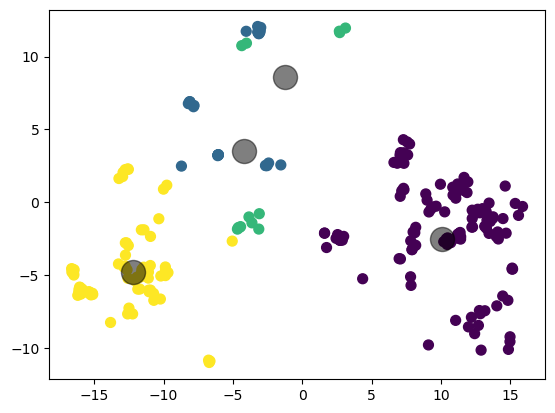

In [26]:
plt.scatter(x_test_reduced[:, 0], x_test_reduced[:, 1], c=y_pred_test_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=300, alpha=0.5);
plt.show()